# Using NumPy

### 1. Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

print("Loading Fashion MNIST data... (this might take a minute)")
mnist = fetch_openml('Fashion-MNIST', version=1, cache=True, as_frame=False)
X_raw, y_raw = mnist.data, mnist.target.astype(int)

subset_size = 2000 
X_raw, y_raw = shuffle(X_raw, y_raw, random_state=42)
X_dataset = X_raw[:subset_size]
y_dataset = y_raw[:subset_size]

print(f"Data Loaded. Shape: {X_dataset.shape}")
print("Classes:", np.unique(y_dataset))

Loading Fashion MNIST data... (this might take a minute)
Data Loaded. Shape: (2000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]


### 2. Create SVM model

In [2]:
class SVMScratch:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.01, lr=0.001, n_iters=1000): # Increased iters
        self.C = C
        self.kernel_type = kernel
        self.gamma = gamma
        self.lr = lr
        self.n_iters = n_iters
        self.alpha = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def _kernel(self, x1, x2):
        if self.kernel_type == 'linear':
            return np.dot(x1, x2.T)
        elif self.kernel_type == 'rbf':
            if x2.ndim == 1:
                x2 = x2.reshape(1, -1)

            x1_sq = np.sum(x1**2, axis=1).reshape(-1, 1)
            x2_sq = np.sum(x2**2, axis=1)
            dist_sq = x1_sq + x2_sq - 2 * np.dot(x1, x2.T)
            return np.exp(-self.gamma * dist_sq)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X_train = X
        self.y_train = y
        self.alpha = np.zeros(n_samples)
        
        K = self._kernel(X, X)
        
        for i in range(self.n_iters):
            
            gradient = 1 - y * np.dot(K, self.alpha * y)
            self.alpha += self.lr * gradient
            
            self.alpha = np.clip(self.alpha, 0, self.C)
            
        sv_indices = self.alpha > 1e-5

        if np.any(sv_indices):
            self.b = np.mean(y[sv_indices] - np.dot(K[sv_indices], self.alpha * y))
        else:
            self.b = 0

    def decision_function(self, X):
        K_pred = self._kernel(X, self.X_train)
        return np.dot(K_pred, self.alpha * self.y_train) + self.b

def train_svm(X, y, C, kernel):
    classes = np.unique(y)
    models = []
    
    gamma = 1.0 / X.shape[1] 
    
    for cls in classes:
        y_binary = np.where(y == cls, 1, -1)
        
        iters = 1000 if kernel == 'rbf' else 1500
        
        svm = SVMScratch(C=C, kernel=kernel, gamma=gamma, n_iters=iters, lr=0.001)
        svm.fit(X, y_binary)
        models.append(svm)
        
    return models

### 3. Define predict function

In [3]:
def predict(models, X):

    scores = np.zeros((X.shape[0], len(models)))
    
    for idx, model in enumerate(models):
        scores[:, idx] = model.decision_function(X)
    
    return np.argmax(scores, axis=1)

### 4. Split Data

In [4]:
def stratified_split(X, y, test_size=0.2):
    classes, counts = np.unique(y, return_counts=True)
    n_test = (counts * test_size).astype(int)
    
    train_indices = []
    test_indices = []
    
    for k, cls in enumerate(classes):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        
        n_t = n_test[k]
        test_indices.extend(cls_indices[:n_t])
        train_indices.extend(cls_indices[n_t:])
        
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = stratified_split(X_dataset, y_dataset, test_size=0.2)
X_train_mu = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0) + 1e-8
X_train = (X_train - X_train_mu) / X_train_std
X_test = (X_test - X_train_mu) / X_train_std

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 1603, Test size: 397


### 5. Acc with predefined Values

In [5]:
print("Training initial model (Kernel=rbf, C=1)...")
models_rbf_1 = train_svm(X_train, y_train, C=1, kernel='rbf')

y_pred = predict(models_rbf_1, X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy with Kernel='rbf' and C=1: {accuracy * 100:.2f}%")

Training initial model (Kernel=rbf, C=1)...
Accuracy with Kernel='rbf' and C=1: 81.11%


### 6. Optimize Hyperparameters

In [6]:
c_values = [0.01, 0.1, 1, 10, 100]
kernels = ['linear', 'rbf']
results = {k: [] for k in kernels}

def get_k_folds(X, y, k=10):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    folds = []
    for i in range(k):
        val_idx = indices[i*fold_size : (i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        folds.append((train_idx, val_idx))
    return folds

folds = get_k_folds(X_train, y_train, k=10)

print("Starting Cross-Validation (this will take time)...")

for kernel in kernels:
    acc_per_c = []
    for C in c_values:
        fold_accuracies = []
        print(f"Running CV for Kernel={kernel}, C={C}", end=' ')
        
        for train_idx, val_idx in folds:
            X_cv_train, y_cv_train = X_train[train_idx], y_train[train_idx]
            X_cv_val, y_cv_val = X_train[val_idx], y_train[val_idx]
            
            curr_models = train_svm(X_cv_train, y_cv_train, C=C, kernel=kernel)
            y_val_pred = predict(curr_models, X_cv_val)
            fold_accuracies.append(np.mean(y_val_pred == y_cv_val))
            
        avg_acc = np.mean(fold_accuracies)
        print(f"=> Avg Accuracy: {avg_acc * 100:.2f}%")
        acc_per_c.append(avg_acc)
    results[kernel] = acc_per_c

Starting Cross-Validation (this will take time)...
Running CV for Kernel=linear, C=0.01 => Avg Accuracy: 16.25%
Running CV for Kernel=linear, C=0.1 => Avg Accuracy: 13.12%
Running CV for Kernel=linear, C=1 => Avg Accuracy: 13.81%
Running CV for Kernel=linear, C=10 => Avg Accuracy: 16.25%
Running CV for Kernel=linear, C=100 => Avg Accuracy: 13.81%
Running CV for Kernel=rbf, C=0.01 => Avg Accuracy: 69.50%
Running CV for Kernel=rbf, C=0.1 => Avg Accuracy: 75.81%
Running CV for Kernel=rbf, C=1 => Avg Accuracy: 81.75%
Running CV for Kernel=rbf, C=10 => Avg Accuracy: 82.94%
Running CV for Kernel=rbf, C=100 => Avg Accuracy: 82.94%


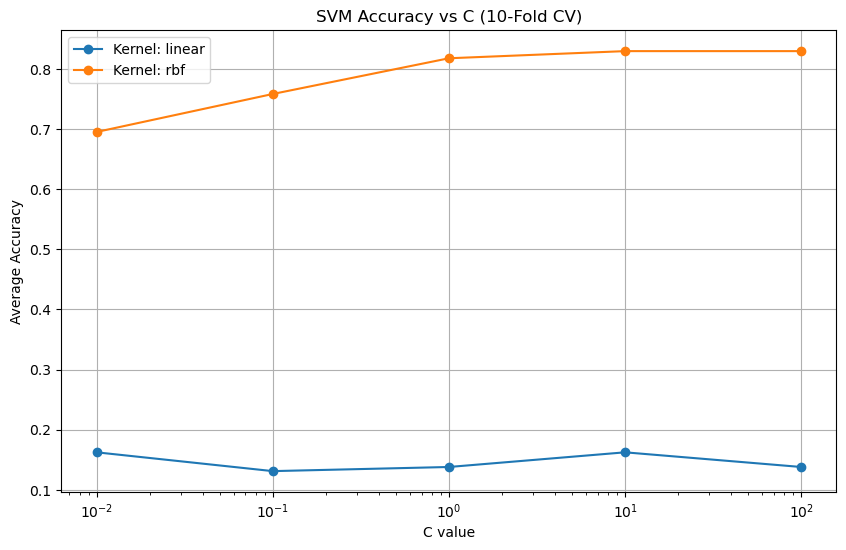

In [7]:
plt.figure(figsize=(10, 6))
for kernel in kernels:
    plt.plot(c_values, results[kernel], marker='o', label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Average Accuracy')
plt.title('SVM Accuracy vs C (10-Fold CV)')
plt.legend()
plt.grid(True)
plt.show()

### 7. Best model

In [8]:
best_score = 0
best_params = {}

for kernel in kernels:
    for idx, acc in enumerate(results[kernel]):
        if acc > best_score:
            best_score = acc
            best_params = {'kernel': kernel, 'C': c_values[idx]}

print(f"Best Parameters found: {best_params} with CV Accuracy: {best_score*100:.2f}%")

print("Retraining on full training set with best parameters...")
final_models = train_svm(X_train, y_train, C=best_params['C'], kernel=best_params['kernel'])

final_pred = predict(final_models, X_test)
final_accuracy = np.mean(final_pred == y_test)

print(f"Final Test Set Accuracy: {final_accuracy * 100:.2f}%")

Best Parameters found: {'kernel': 'rbf', 'C': 10} with CV Accuracy: 82.94%
Retraining on full training set with best parameters...
Final Test Set Accuracy: 82.62%


              precision    recall  f1-score   support

           0       0.83      0.81      0.82        42
           1       1.00      0.94      0.97        34
           2       0.74      0.68      0.71        38
           3       0.77      0.88      0.82        41
           4       0.67      0.79      0.72        38
           5       0.90      0.90      0.90        41
           6       0.66      0.50      0.57        42
           7       0.92      0.87      0.89        38
           8       0.90      0.93      0.91        40
           9       0.89      0.98      0.93        43

    accuracy                           0.83       397
   macro avg       0.83      0.83      0.83       397
weighted avg       0.83      0.83      0.82       397



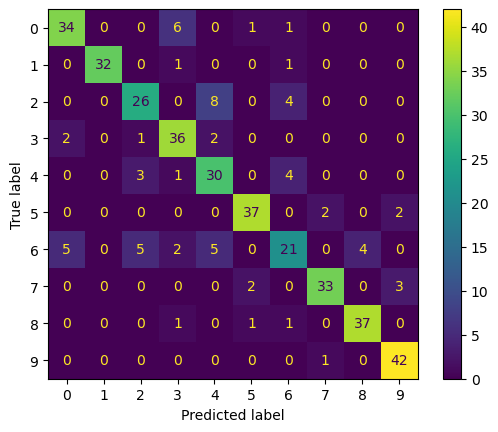

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay(confusion_matrix(y_test, final_pred)).plot()
print(classification_report(y_test, final_pred))

# Using Scikit-Learn

### 1. Load and preprocess data

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


X = mnist.data 
y = mnist.target.astype(int)
train_size = 1600
test_size = 400
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2. test model with predefined values

In [11]:
print("Training specific model (RBF, C=1)...")

clf_specific = OneVsRestClassifier(SVC(kernel='rbf', C=1.0))
clf_specific.fit(X_train, y_train)

acc_specific = clf_specific.score(X_test, y_test)
print(f"Accuracy (RBF, C=1) on Test Set: {acc_specific * 100:.2f}%")

Training specific model (RBF, C=1)...
Accuracy (RBF, C=1) on Test Set: 82.25%


### 3. Optimize Hyperparameters

In [12]:
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],
    'estimator__kernel': ['rbf', 'linear']
}

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=OneVsRestClassifier(SVC()),
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,  
    verbose=3
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,OneVsRestClas...timator=SVC())
,param_grid,"{'estimator__C': [0.01, 0.1, ...], 'estimator__kernel': ['rbf', 'linear']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


### 4. Plot Results

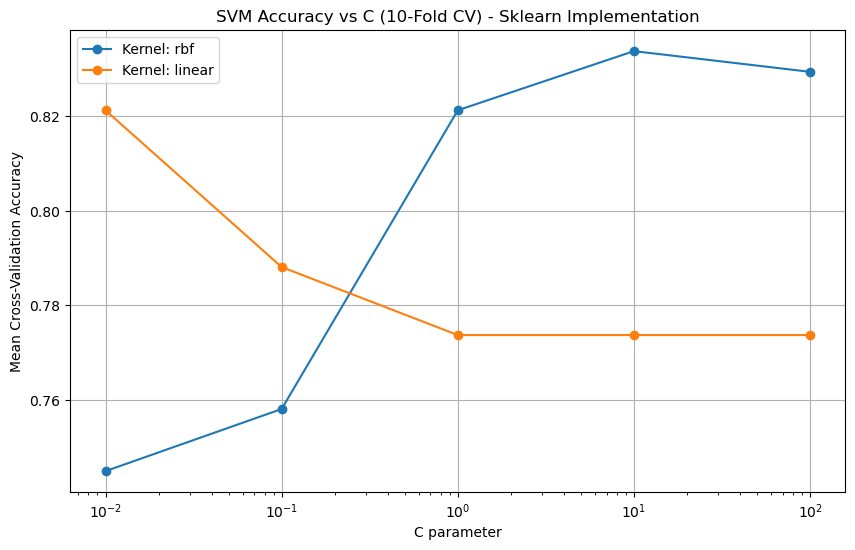

In [13]:
results = grid_search.cv_results_
means = results['mean_test_score']
params = results['params']

c_vals = [0.01, 0.1, 1, 10, 100]
kernels = ['rbf', 'linear']

plt.figure(figsize=(10, 6))

for kernel in kernels:
    acc_scores = []
    for c in c_vals:
        for i, p in enumerate(params):
            if p['estimator__kernel'] == kernel and p['estimator__C'] == c:
                acc_scores.append(means[i])
                break
    
    plt.plot(c_vals, acc_scores, marker='o', label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xlabel('C parameter')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('SVM Accuracy vs C (10-Fold CV) - Sklearn Implementation')
plt.legend()
plt.grid(True)
plt.show()

### 5. find best model and its Accuracy

In [14]:
print("Best Parameters found:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_ * 100:.2f}%")

Best Parameters found: {'estimator__C': 10, 'estimator__kernel': 'rbf'}
Best CV Accuracy: 83.38%


In [17]:
best_model = grid_search.best_estimator_
final_acc = best_model.score(X_test, y_test)

print(f"Final Accuracy on Held-out Test Set: {final_acc * 100:.2f}%")

Final Accuracy on Held-out Test Set: 82.50%


              precision    recall  f1-score   support

           0       0.65      0.80      0.72        40
           1       1.00      0.93      0.96        40
           2       0.71      0.72      0.72        40
           3       0.88      0.70      0.78        40
           4       0.74      0.85      0.79        40
           5       0.92      0.88      0.90        40
           6       0.67      0.55      0.60        40
           7       0.95      0.90      0.92        40
           8       0.83      0.97      0.90        40
           9       0.97      0.95      0.96        40

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



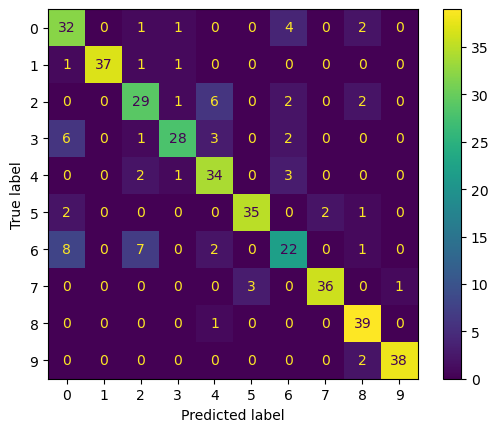

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay(confusion_matrix(y_test, best_model.predict(X_test))).plot()
print(classification_report(y_test, best_model.predict(X_test)))